In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display
from eigentools import Eigenproblem, CriticalFinder

In [3]:
#Aspect ratio 2
Ly= 1
ny = 192

# Create bases and domain\
y_basis = de.Chebyshev('y',ny, interval=(-Ly/2, Ly/2), dealias=3/2)
domain = de.Domain([y_basis], grid_dtype=np.complex128)

### Terms on the left side of the equation are treated explicitly while terms on the right side are treated implicity. So if terms are non-linear put them on the right side I guess.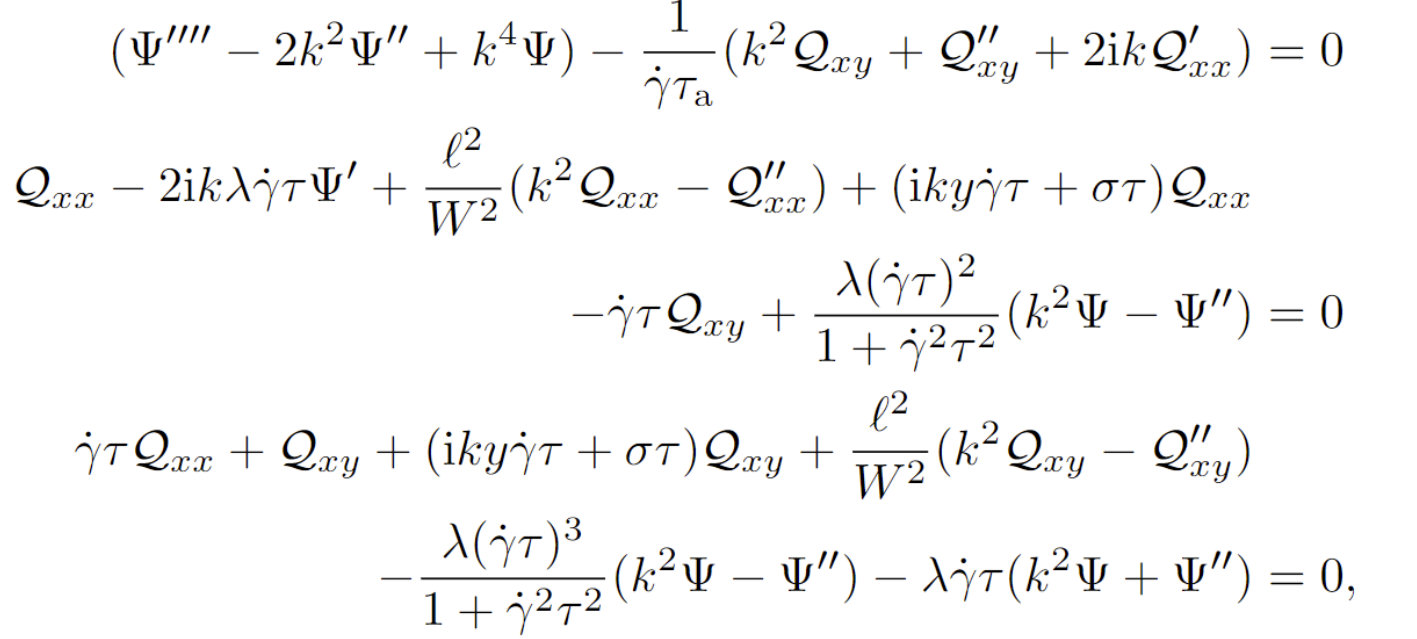

In [4]:
# Define the equations
a = 1
k = 1
l = 1
W = 10
lamb = 1
tau = 1
gammaDot = 2
tBar = tau * gammaDot

problem = de.EVP(domain, ['Psi','Psi1','Psi2','Psi3','Qxx','Qxy','Qxx1','Qxy1'], 'sigma')
problem.meta[:]['y']['dirichlet'] = True
Ly = 1
problem.parameters['Ly'] = Ly
problem.parameters['a'] = a
problem.parameters['k'] = k
problem.parameters['l'] = l
problem.parameters['W'] = W
problem.parameters['lamb'] = lamb
problem.parameters['tau'] = tau
problem.parameters['gammaDot'] = gammaDot
problem.parameters['tBar'] = tBar
problem.add_equation("dy(Psi3) - 2*(k**2)*dy(Psi1) + (k**4)*Psi - a * ((k**2)*Qxy + dy(Qxy1) + 2j*k*dy(Qxx)) = 0")
problem.add_equation("Qxx - 2j*k*lamb*tBar*dy(Psi)" 
                    "+ (l**2/W**2)*(k**2 * Qxx - dy(Qxx1)) + (1j*k*y*tBar + sigma*tau)*Qxx - tBar*Qxy" 
                    "+ (lamb * (tBar**2)) / (1 + tBar**2) * (k**2 * Psi - dy(Psi1)) = 0")
problem.add_equation("tBar*Qxx + Qxy + (1j*k*y*tBar + sigma*tau)*Qxy + (l**2/W**2)*(k**2 * Qxy - dy(Qxy1)) - (lamb * tBar**3)/(1+tBar**2)*(k**2 * Psi - dy(Psi1)) - lamb*tBar*(k**2*Psi + dy(Psi1)) = 0")
problem.add_equation("dy(Psi2)=Psi3")
problem.add_equation("dy(Psi1)=Psi2")
problem.add_equation("dy(Psi)=Psi1")
problem.add_equation("dy(Qxx) = Qxx1")
problem.add_equation("dy(Qxy) = Qxy1")

2022-10-18 22:09:30,793 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [14]:
# Set the BCs
problem.add_bc("left(dy(Qxx)) = 0")
problem.add_equation("right(dy(Qxx)) = 0")
problem.add_equation("left(dy(Qxy)) = 0")
problem.add_equation("right(dy(Qxy)) = 0")
problem.add_equation("left(Psi) = 0")
problem.add_equation("right(Psi) = 0")
# Deal with these BCs with substituation trick.
problem.add_equation("left(dy(Psi))=0")
problem.add_equation("right(dy(Psi))=0")

In [6]:
g_func = lambda z: z.real
f_func = lambda z: z.imag
ep = Eigenproblem(problem, grow_func=g_func, freq_func=f_func)

2022-10-18 22:09:31,979 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [7]:
%%time
rate, index, freq = ep.growth_rate(parameters={'k':k, 'tBar': tBar, 'a':a}, sparse=False)

CPU times: user 12min 23s, sys: 9.56 s, total: 12min 33s
Wall time: 12min 36s


In [10]:
print("fastest growing mode: {}-th mode, Re(signa)={} @ freq {}".format(index, rate, freq))

fastest growing mode: 203-th mode, Re(signa)=-1.0071838893545282 @ freq 1.3050553009501973


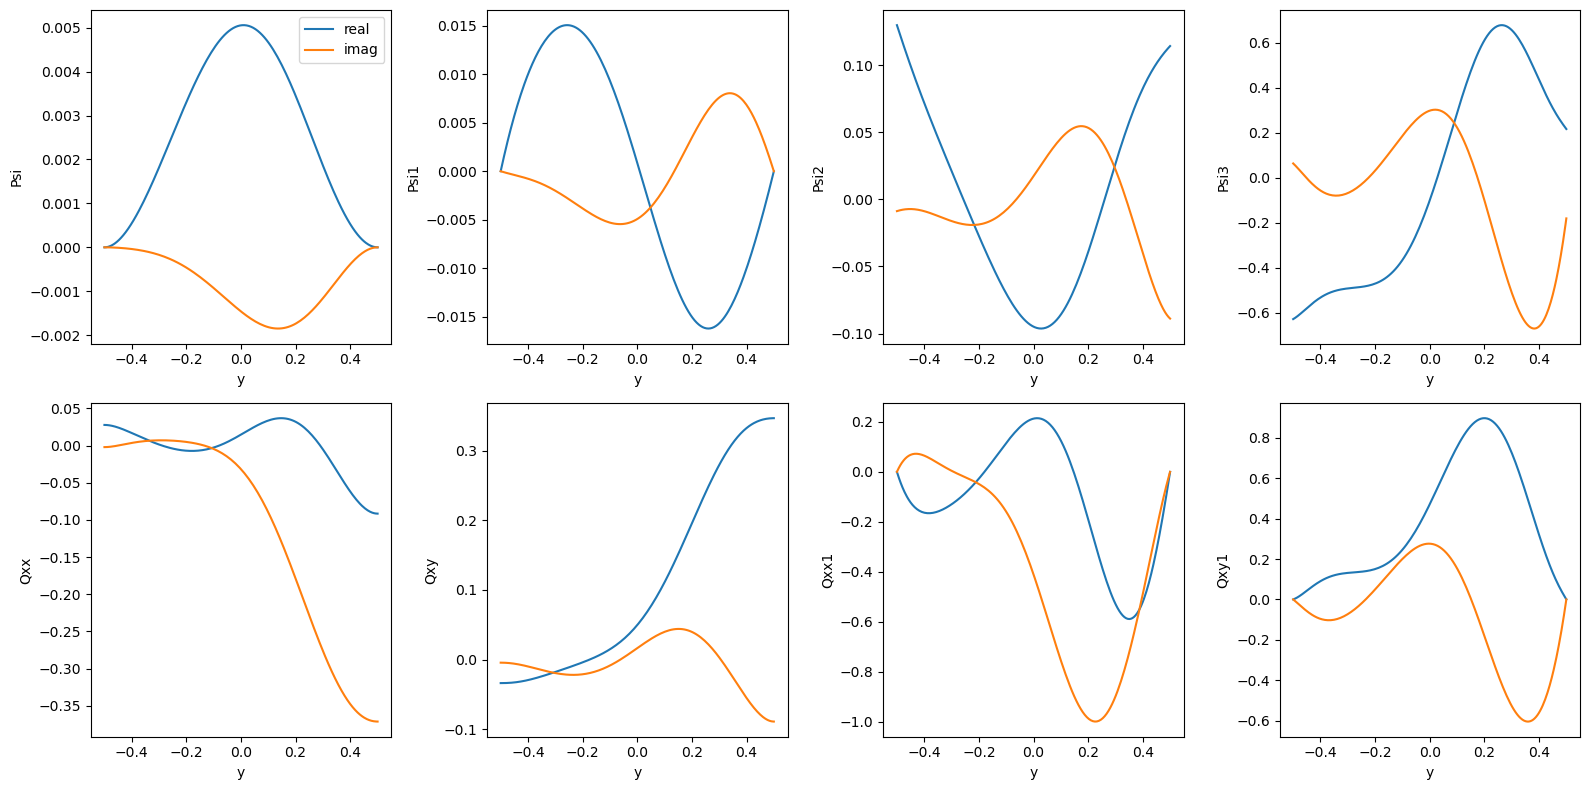

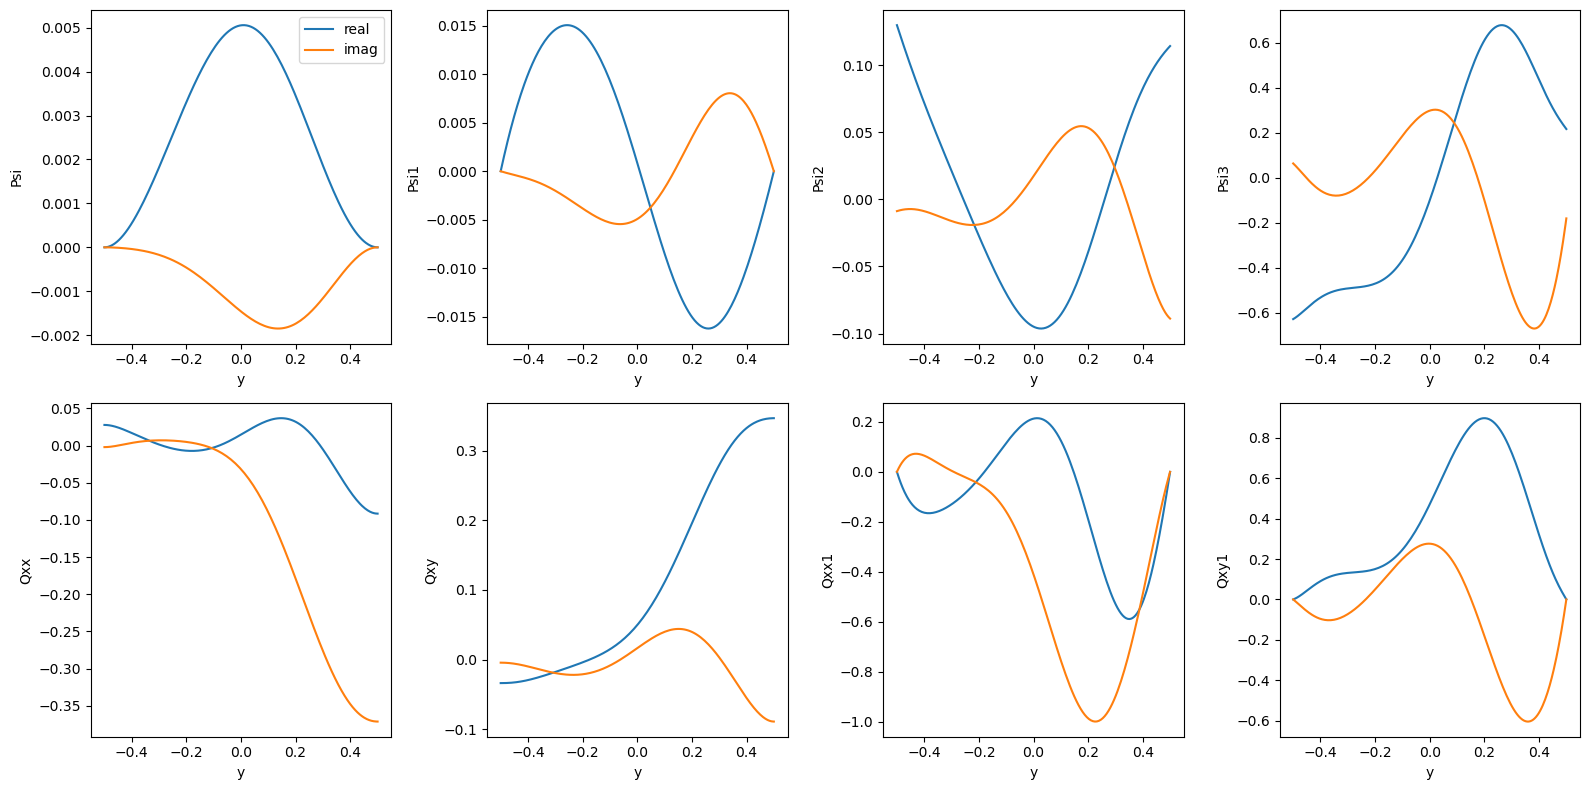

In [11]:
ep.plot_mode(203)